In [58]:
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataloader import default_collate

import time
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

In [59]:
# torch.cuda.empty_cache() полностью чистит память графического процессора

In [60]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224), antialias = True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=35, translate=(0.3, 0.3))
    ])

BATCH_SIZE = 128
TEST_SIZE = 0.1

ROOT = ''
NET_NAME_1 = 'net_1.pt'
NET_NAME_2 = 'net_2.pt'
DATASET_FOLDER = 'dataset_by_classes'
DATA_ROOT = DATASET_FOLDER

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [61]:
dataset = datasets.ImageFolder(DATASET_FOLDER, 
                               transform=transform)
classes = dataset.classes
classes

['1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '15',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '16',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '17',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '18',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '188',
 '189',
 '19',
 '190',
 '191',
 '192',
 '193',
 '194',
 '195',
 '196',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '3

In [62]:
test_len = int(TEST_SIZE*len(dataset))
train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, test_len])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  
                                        collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, 
                                        collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))
print(len(train_set),len(test_set))

6289 698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])


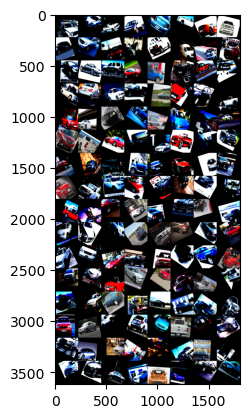

In [63]:
def imshow(img):
    img_np = img.cpu().numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break


In [64]:
def save_model(model, path, name):
  model_scripted = torch.jit.script(model)
  model_scripted.save(path + name)

In [65]:
def my_accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {test_len} test images: {100 * correct // total} %')
    return 100 * correct // total

def my_accuracy_per_classes(model, test_loader, classes):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    return correct_pred.items()

In [66]:
def fit(model, train_dataloader, optim, criterion):
    model.train()
    train_running_loss = 0.0
    all_loss = []
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optim.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optim.step()
        
        train_running_loss += loss.item()
        all_loss.append(loss.item())
        if (i+1) % 3 == 0 :
          print((i+1), '/', len(train_dataloader.dataset) / BATCH_SIZE, ': loss = ', loss.item())
        
    mean_loss = train_running_loss/ (len(train_dataloader.dataset) / BATCH_SIZE)
    print(f'Mean epoch loss: {mean_loss:.4f}')
    
    return mean_loss, all_loss

#VGG16

In [10]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(DEVICE)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# меняем число выходов
vgg16.classifier[6].out_features = len(dataset.classes)

# замораживаем веса сверточных слоев
for param in vgg16.features.parameters():
    param.requires_grad = False

In [12]:
# optimizer
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.01)
# loss function
criterion = nn.CrossEntropyLoss()
MAX_EPOCHS = 5

In [13]:
import gc
torch.cuda.empty_cache()
gc.collect()

9

In [14]:
epoch_mean_loss = []
all_loss = []
for epoch in range(MAX_EPOCHS): 
    mean_loss, epoch_losses = fit(vgg16, train_loader, optimizer, criterion)
    epoch_mean_loss.append(mean_loss)
    all_loss.extend(epoch_losses)
print('Finished Training')
save_model(vgg16, './', NET_NAME_1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 4.00 GiB total capacity; 2.29 GiB already allocated; 0 bytes free; 3.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(epoch_mean_loss, color='green', label='train epoch losses')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(all_loss, color='green', label='train all losses')
plt.legend()
plt.show()

In [ ]:
my_accuracy(vgg16, test_loader)
my_accuracy_per_classes(vgg16, test_loader, classes)

NameError: ignored

In [ ]:
# for epoch in range(4): 
#     running_loss = 0.0
#     for j, data in enumerate(train_loader, 0):
#         inputs, labels = data

#         optimizer.zero_grad()

#         outputs = vgg16(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if j % 20 == 0: 
#             print(f'[{epoch + 1}, {j + 1:5d}] loss: {running_loss / 20:.3f}')
#             running_loss = 0.0
# print('Finished Training')
# save_model(vgg16, './', NET_NAME_1)

#ResNet50

In [67]:
# Инициализация модели
class MyResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.fc = nn.Linear(1000, 196)
        self.resnet50.requires_grad = False
        for param in self.resnet50.parameters():
            param.requires_grad = False

    # Это forward функция, которая определяет структуру сети.
    # Здесь мы принимаем только один вход, но можно использовать больше.
    def forward(self, x):
        x = nn.functional.relu(self.resnet50(x))
        x = nn.functional.relu(self.fc(x))
        return x

In [68]:
resnet50 = MyResNet50()
resnet50.to(DEVICE)
print(resnet50)

MyResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [69]:
# optimizer
optimizer_resnet50 = optim.Adam(resnet50.fc.parameters(), lr=0.01)
# loss function
criterion = nn.CrossEntropyLoss()
MAX_EPOCHS = 5

In [70]:
import gc
torch.cuda.empty_cache()
gc.collect()

6590

In [71]:
epoch_mean_loss = []
all_loss = []
for epoch in range(MAX_EPOCHS): 
    mean_loss, epoch_losses = fit(resnet50, train_loader, optimizer_resnet50, criterion)
    epoch_mean_loss.append(mean_loss)
    all_loss.extend(epoch_losses)
print('Finished Training')
save_model(resnet50, './', NET_NAME_2)

OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 4.00 GiB total capacity; 2.69 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

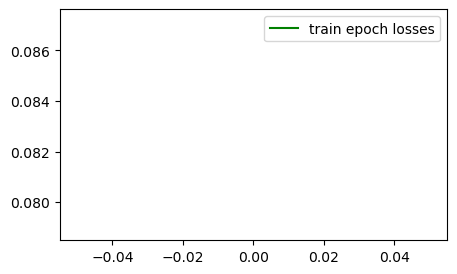

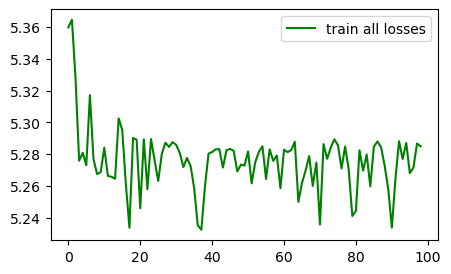

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(epoch_mean_loss, color='green', label='train epoch losses')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(all_loss, color='green', label='train all losses')
plt.legend()
plt.show()

In [ ]:
my_accuracy(resnet50, test_loader)
my_accuracy_per_classes(resnet50, test_loader, classes)

Accuracy of the network on the 698 test images: 0 %
Accuracy for class: 1     is 0.0 %
Accuracy for class: 10    is 0.0 %
Accuracy for class: 100   is 0.0 %
Accuracy for class: 101   is 0.0 %
Accuracy for class: 102   is 0.0 %
Accuracy for class: 103   is 0.0 %
Accuracy for class: 104   is 0.0 %
Accuracy for class: 105   is 0.0 %
Accuracy for class: 106   is 0.0 %
Accuracy for class: 107   is 0.0 %
Accuracy for class: 108   is 0.0 %
Accuracy for class: 109   is 0.0 %
Accuracy for class: 11    is 0.0 %
Accuracy for class: 110   is 0.0 %
Accuracy for class: 111   is 0.0 %
Accuracy for class: 112   is 0.0 %
Accuracy for class: 113   is 33.3 %
Accuracy for class: 114   is 0.0 %
Accuracy for class: 115   is 0.0 %
Accuracy for class: 116   is 0.0 %


ZeroDivisionError: float division by zero